In [173]:
from scipy.linalg import toeplitz
from numpy import linalg as LA
import numpy as np
import torch.nn.functional as F
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [174]:
def get_2D_toeplitz(kernel, input_dims):
    img_row, img_col = input_dims
    k_row, k_col = kernel.size()
    t_row = img_row+k_row-1
    t_col = img_col+k_col-1
    print(t_row, t_col)
    padded_kernel = F.pad(kernel, pad=(0, t_col-k_col, 0, t_row-k_row))
    pk_row, pk_col = padded_kernel.shape
    toeplitz_blocks = [ toeplitz(row, pk_row) for row in padded_kernel]
    res_col = torch.arange(1, len(toeplitz_blocks)+1)
    res_row = torch.zeros()
    res_row[0] = 1
    shape = toeplitz(res_col, res_row).flatten('F')
    zero_block = np.zeros((padded_kernel.size(1), t_row))
    ordered_blocks = []
    for block_id in shape:
        if block_id == 0:
            ordered_blocks.append(zero_block)
        else:
            ordered_blocks.append(toeplitz_blocks[block_id-1])
    return np.vstack(np.dstack(np.stack(ordered_blocks).reshape((2,3,padded_kernel.size(0),t_row))))

/tmp/ipykernel_36133/1190924832.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


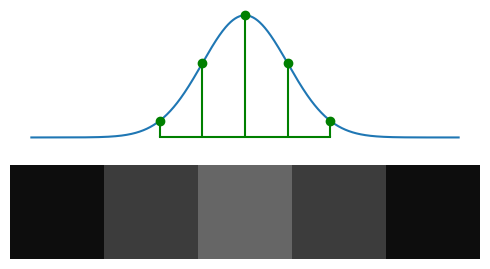

In [177]:
mu = 0       # Mean
sigma = 1 # Standard deviation

# Create x values
x = np.linspace(-5, 5, 1000)

# Calculate the Gaussian function
gaussian = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma)**2)

# Calculate the Gaussian heights at specific x-values
x_values = [ -2, -1, 0, 1, 2]
gaussian_heights = [(1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma)**2) for x in x_values]

# Create impulses at specific x-values with matching heights
impulse_x = x_values
impulse_y = gaussian_heights

fig, axes = plt.subplots(2, 1, figsize=(5, 3))
axes[0].plot(x, gaussian)
axes[0].stem(impulse_x, impulse_y, 'g', markerfmt='go', linefmt='g-',basefmt='g')
axes[0].axis('off')
axes[1].imshow(np.array(gaussian_heights).reshape((1, 5)), cmap='gray', vmin=0, vmax=1)
axes[1].axis('off')
fig.tight_layout()
fig.show()
fig.savefig('images/toeplitz_1d_kernel.png')

In [209]:
print(gaussian_heights)

[0.05399096651318805, 0.24197072451914337, 0.3989422804014327, 0.24197072451914337, 0.05399096651318805]


In [210]:
kernel = torch.from_numpy(np.array(gaussian_heights))

In [211]:
clean_img = torch.zeros(16)
for i in range(1,9):
    clean_img[i + 4] = 1
clean_img[8] = 0

In [212]:
def convolve_1d_toeplitz(kernel, input_size):
    M_I = input_size
    M_K = kernel.size(0)
    M_O = M_I-M_K+1
    # create the toeplitz row and col as the toeplitz matrix is totally definable with both
    toeplitz_row = F.pad(kernel.unsqueeze(0), pad=(0, M_I-M_K)).squeeze()
    toeplitz_col = torch.zeros(M_O, dtype=torch.float)
    toeplitz_col[0] = toeplitz_row[0]
    #create matrix
    return torch.from_numpy(toeplitz(toeplitz_col, toeplitz_row)).to(torch.float)

In [213]:
matrix = convolve_1d_toeplitz(kernel, clean_img.size(0))
output = torch.matmul(matrix, clean_img)

/tmp/ipykernel_36133/2229448088.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


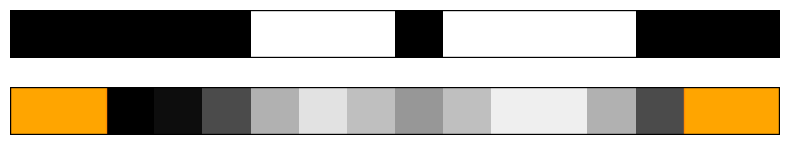

In [228]:
fig, axes = plt.subplots(2, 1, figsize=(8, 2))
axes[0].imshow(np.array(clean_img).reshape((1, 16)), cmap='gray', vmin=0, vmax=1)
axes[0].add_patch(patches.Rectangle((-0.5, -0.5), 15.98, 0.98, linewidth=1, edgecolor='black',facecolor='none'))
axes[0].axis('off')
axes[1].imshow(np.array(F.pad(output.unsqueeze(0), (2,2))).reshape((1, 16)), cmap='gray', vmin=0, vmax=1)
axes[1].add_patch(patches.Rectangle((-0.5, -0.5), 2, 1, linewidth=1, edgecolor='darkorange',facecolor='orange'))
axes[1].add_patch(patches.Rectangle((13.5, -0.5), 2, 1, linewidth=1, edgecolor='darkorange',facecolor='orange'))
axes[1].add_patch(patches.Rectangle((-0.5, -0.5), 15.98, 0.98, linewidth=1, edgecolor='black',facecolor='none'))
#axes[1].axvline(x = 1.5, color = 'r')
#axes[1].axvline(x = 13.5, color = 'r')
axes[1].axis('off')
fig.tight_layout()
fig.show()
fig.savefig('images/toeplitz_output.png')

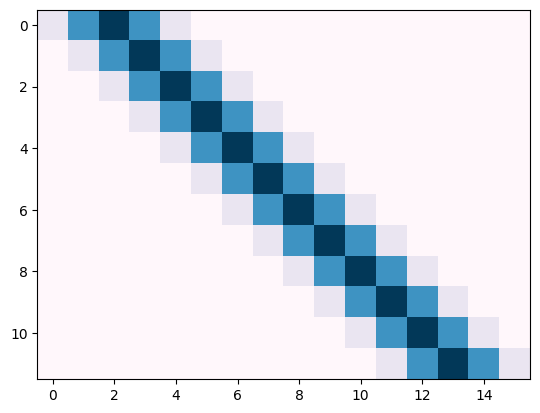

In [229]:
plt.imshow(matrix, cmap='PuBu')
plt.savefig('images/toeplitz_matrix.png')

In [230]:
LA.cond(matrix, p=2)

36.792027

In [237]:
x = []
condition_number = []
for i in tqdm(range(5, 256, 1)):
    ker = torch.from_numpy(np.array(gaussian_heights))
    mat = convolve_1d_toeplitz(ker, i)
    x.append(i)
    condition_number.append(LA.cond(mat, p=2))


100%|██████████| 251/251 [00:02<00:00, 95.81it/s]  


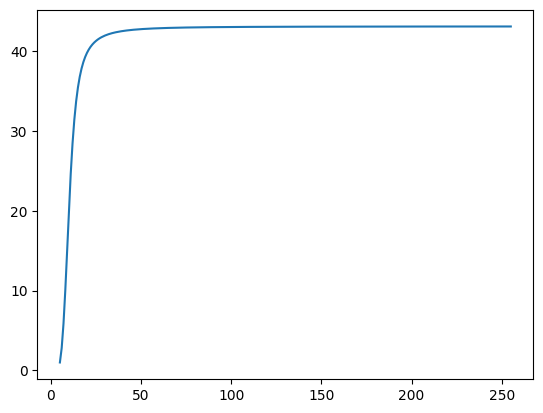

In [238]:
plt.plot(x, condition_number, label='condition number')
plt.show()

In [239]:
input_size = 256
ker_size = []
ker_condition_number =[]
for i in tqdm(range(3, 128, 2)):
    ker = torch.from_numpy(np.array([(1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma)**2) for x in np.linspace(-4, 4, i)]))
    mat = convolve_1d_toeplitz(ker, input_size)
    ker_size.append(i)
    ker_condition_number.append(LA.cond(mat, p=2))


100%|██████████| 63/63 [00:02<00:00, 24.77it/s]


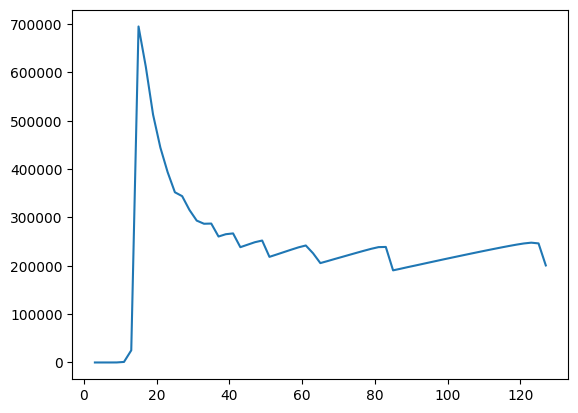

In [240]:
plt.plot(ker_size, ker_condition_number, label='condition number')
plt.show()

/tmp/ipykernel_36133/4290886736.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


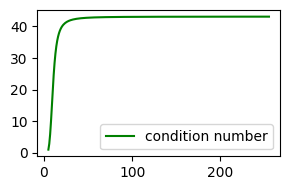

In [252]:
fig, axes = plt.subplots(1, 1, figsize=(3,2))
axes.plot(x, condition_number, c='green', label='condition number')
axes.legend()
#axes[1].plot(ker_size, ker_condition_number, c='orange', label='condition number')
#axes[1].legend()
#axes[2].imshow(matrix, cmap='PuBu')
fig.tight_layout()
fig.show()
fig.savefig('images/toeplitz_matrix_cond_matrix_size.png')

/tmp/ipykernel_36133/1701752715.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


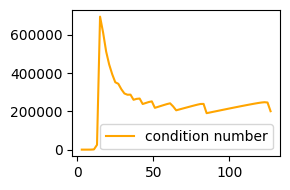

In [254]:
fig, axes = plt.subplots(1, 1, figsize=(3,2))
axes.plot(ker_size, ker_condition_number, c='orange', label='condition number')
axes.legend()
fig.tight_layout()
fig.show()
fig.savefig('images/toeplitz_matrix_cond_kernel_size.png')

/tmp/ipykernel_36133/3752465164.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


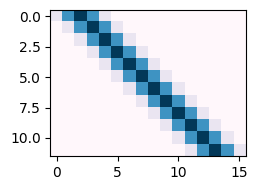

In [256]:
fig, axes = plt.subplots(1, 1, figsize=(3,2))
#axes.plot(x, condition_number, c='green', label='condition number')
#axes.legend()
#axes[1].plot(ker_size, ker_condition_number, c='orange', label='condition number')
#axes[1].legend()
axes.imshow(matrix, cmap='PuBu')
fig.tight_layout()
fig.show()
fig.savefig('images/toeplitz_matrix.png')